# **FORECAST PROJECT**

**The full project covers :**

1.   Loading the data.
2.   Splitting it.
3.   Training multiple models.
4.   Forecasting for future sales.
5.   Visualizing the results.



#Load


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Inventory app.xlsx to Inventory app.xlsx


In [8]:
data = pd.read_excel('Inventory app.xlsx')




In [9]:
# Display the first few rows of the DataFrame to ensure it's loaded correctly
print(data.head())

        date  sales  Inventory h
0 2022-10-14     87           92
1 2022-10-17     97           97
2 2022-10-18     84           85
3 2022-10-19    104          105
4 2022-10-20    105          106


In [10]:
# Rename 'Inventory h' to 'inventory'
data.rename(columns={'Inventory h': 'inventory'}, inplace=True)


In [11]:
# Display the first few rows of the DataFrame to ensure it's loaded correctly
print(data.head())

        date  sales  inventory
0 2022-10-14     87         92
1 2022-10-17     97         97
2 2022-10-18     84         85
3 2022-10-19    104        105
4 2022-10-20    105        106


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       522 non-null    datetime64[ns]
 1   sales      522 non-null    int64         
 2   inventory  522 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 12.4 KB


In [13]:
data.isnull().sum()

,0
date,0
sales,0
inventory,0


In [14]:
data.duplicated().sum()

0

In [15]:
data.isna().sum()

,0
date,0
sales,0
inventory,0


In [16]:
#checking for negative data
data[data['sales'] < 0]

,date,sales,inventory


In [17]:
#checking for negative data
data[data['inventory'] < 0]

,date,sales,inventory


In [18]:
data.describe()

,date,sales,inventory
count,522,522.000000,522.000000
mean,2023-10-14 12:00:00,99.526820,101.825670
min,2022-10-14 00:00:00,80.000000,80.000000
25%,2023-04-14 18:00:00,90.000000,92.000000
50%,2023-10-14 12:00:00,100.000000,102.000000
75%,2024-04-14 06:00:00,110.000000,112.000000
max,2024-10-14 00:00:00,119.000000,124.000000
std,NaN,11.569213,11.697822


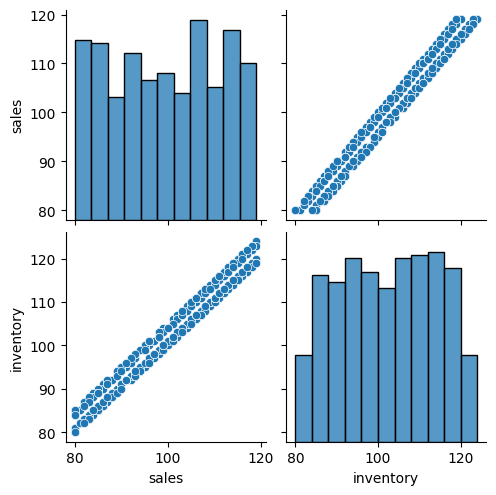

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data)
plt.show()

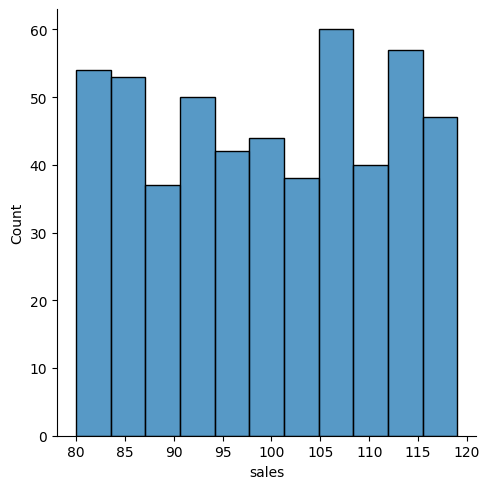

In [20]:
sns.displot(data['sales'])
plt.show()

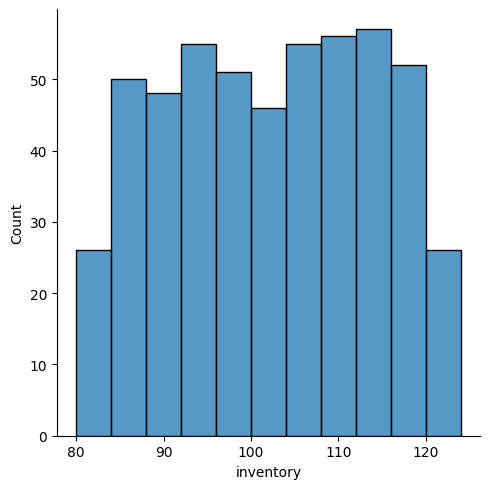

In [21]:
sns.displot(data['inventory'])
plt.show()

#Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

In [23]:
!pip install pmdarima
!pip install prophet
!pip install xgboost
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


#Prepare Data

In [24]:
df=data.copy()

In [25]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Display the first few rows to ensure the data is loaded correctly
print(df.head())

# Feature engineering: create day of week, month, year columns for modeling
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Check for missing values and handle them (if necessary)
df.fillna(method='ffill', inplace=True)

        date  sales  inventory
0 2022-10-14     87         92
1 2022-10-17     97         97
2 2022-10-18     84         85
3 2022-10-19    104        105
4 2022-10-20    105        106


<ipython-input-25-80b36fe60e4c>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# Flexible Data Splitting Function

In [26]:
def split_data(df, split_ratio):
    """
    Function to split the data according to a given ratio.

    Parameters:
    df (DataFrame): The dataframe containing the time series data.
    split_ratio (float): The percentage of data to be used for training (e.g., 0.7 for 70/30 split).

    Returns:
    train (DataFrame): The training set.
    test (DataFrame): The test set.
    """
    train_size = int(len(df) * split_ratio)
    train, test = df[:train_size], df[train_size:]
    return train, test

# Example: Splitting data with 70/30 ratio
train, test = split_data(df, 0.7)

In [27]:
train

,date,sales,inventory,day_of_week,month,year
0,2022-10-14,87,92,4,10,2022
1,2022-10-17,97,97,0,10,2022
2,2022-10-18,84,85,1,10,2022
3,2022-10-19,104,105,2,10,2022
4,2022-10-20,105,106,3,10,2022
...,...,...,...,...,...,...
360,2024-03-01,119,119,4,3,2024
361,2024-03-04,83,87,0,3,2024
362,2024-03-05,84,88,1,3,2024
363,2024-03-06,84,88,2,3,2024


#Model Training and Predictions

##Model 1: ARIMA

In [28]:
# Train ARIMA model
arima_model = ARIMA(train['sales'], order=(5,1,0))
arima_result = arima_model.fit()

# Predict
arima_pred = arima_result.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test['sales'], arima_pred))
print(f'ARIMA RMSE: {arima_rmse}')

ARIMA RMSE: 10.992386325684105


In [29]:
#arima_model = ARIMA(train['sales'], order=(5,1,0))
#arima_result = arima_model.fit()

##Model 2: SARIMA

In [30]:
# Train SARIMA model
sarima_model = SARIMAX(train['sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

# Predict
sarima_pred = sarima_result.forecast(steps=len(test))
sarima_rmse = np.sqrt(mean_squared_error(test['sales'], sarima_pred))
print(f'SARIMA RMSE: {sarima_rmse}')

SARIMA RMSE: 11.07186383611354


In [31]:
#sarima_model = SARIMAX(train['sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
#sarima_result = sarima_model.fit()

##Model 3: Prophet

In [32]:
# Prepare data for Prophet
prophet_train = train.reset_index()[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
prophet_test = test.reset_index()[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})


# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Make future predictions for the test set
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Get the predicted values corresponding to the test period
prophet_pred = forecast['yhat'][-len(test):].values  # Extract predicted sales values for the test set

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp009pa9j3/o5icz4jq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp009pa9j3/b0c0dr61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62555', 'data', 'file=/tmp/tmp009pa9j3/o5icz4jq.json', 'init=/tmp/tmp009pa9j3/b0c0dr61.json', 'output', 'file=/tmp/tmp009pa9j3/prophet_modelwl7jfia4/prophet_model-20241022133845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:38:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Calculate RMSE for Prophet model
from sklearn.metrics import mean_squared_error
prophet_rmse = np.sqrt(mean_squared_error(test['sales'], prophet_pred))
print(f'Prophet RMSE: {prophet_rmse}')

Prophet RMSE: 12.31513247914127


In [34]:
#prophet_model = Prophet()
#prophet_model.fit(prophet_train)

##Model 4: Random Forest

In [35]:
# Train Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(train[['day_of_week', 'month', 'year']], train['sales'])

# Predict
rf_pred = rf_model.predict(test[['day_of_week', 'month', 'year']])
rf_rmse = np.sqrt(mean_squared_error(test['sales'], rf_pred))
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest RMSE: 11.937903042870984


In [36]:
#rf_model.fit(X_train, y_train)

##Model 5: XGBoost

In [37]:
# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(train[['day_of_week', 'month', 'year']], train['sales'])

# Predict
xgb_pred = xgb_model.predict(test[['day_of_week', 'month', 'year']])
xgb_rmse = np.sqrt(mean_squared_error(test['sales'], xgb_pred))
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoost RMSE: 13.87861157761686


In [38]:
#xgb_model.fit(X_train, y_train)

##Model 6: Linear Regression

In [39]:
# Train Linear Regression model
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(train[['day_of_week', 'month', 'year']], train['sales'])

# Predict
lr_pred = lr_model.predict(test[['day_of_week', 'month', 'year']])
lr_rmse = np.sqrt(mean_squared_error(test['sales'], lr_pred))
print(f'Linear Regression RMSE: {lr_rmse}')

Linear Regression RMSE: 10.719895894943194


In [40]:
#X_train = train[['day_of_week', 'month', 'year']]
#y_train = train['sales']
#lr_model.fit(X_train, y_train)

# Visualize Actual vs Predicted Results

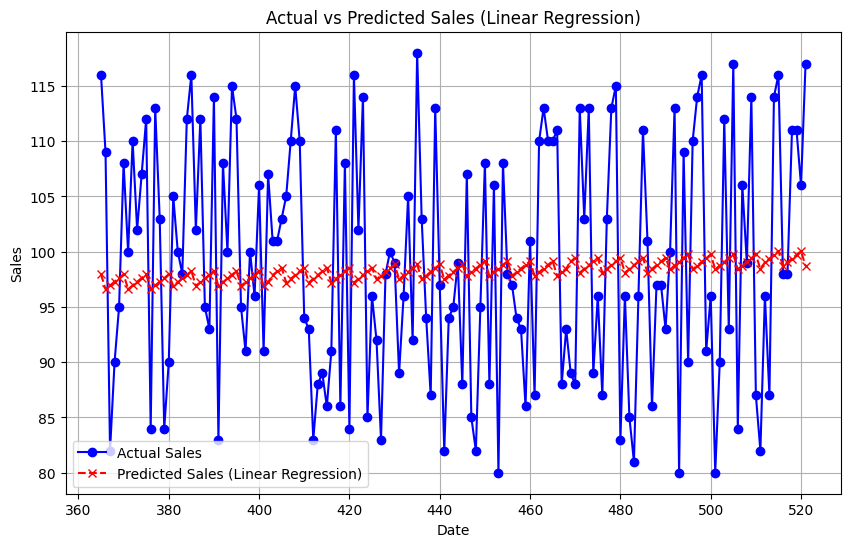

In [41]:
def plot_actual_vs_predicted(test, predicted, model_name):
    plt.figure(figsize=(10,6))
    plt.plot(test.index, test['sales'], label='Actual Sales', color='blue', marker='o')
    plt.plot(test.index, predicted, label=f'Predicted Sales ({model_name})', color='red', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted Sales ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for Linear Regression
plot_actual_vs_predicted(test, lr_pred, 'Linear Regression')

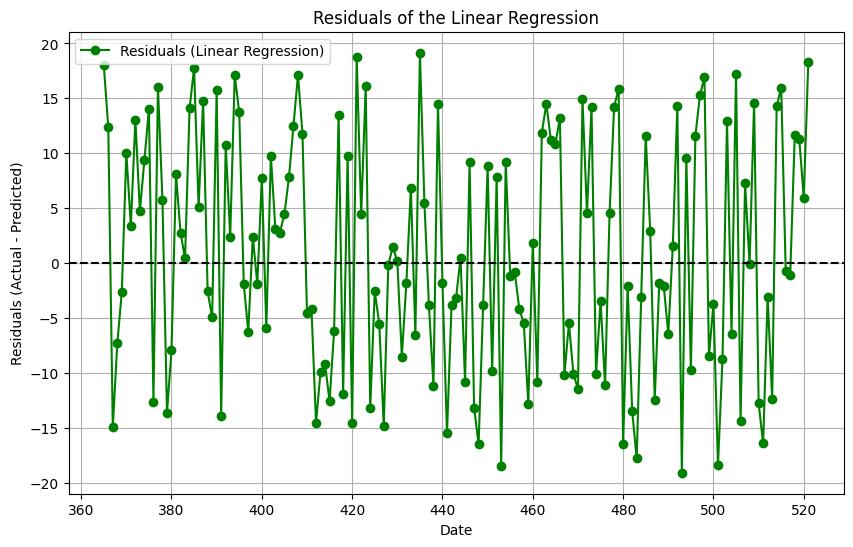

In [42]:
def plot_residuals(test, predicted, model_name):
    residuals = test['sales'] - predicted
    plt.figure(figsize=(10,6))
    plt.plot(test.index, residuals, label=f'Residuals ({model_name})', color='green', marker='o')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f'Residuals of the {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for Linear Regression
plot_residuals(test, lr_pred, 'Linear Regression')

#Compare Models

In [43]:
# Print RMSE of all models
print(f'ARIMA RMSE: {arima_rmse}')
print(f'SARIMA RMSE: {sarima_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')
print(f'Random Forest RMSE: {rf_rmse}')
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'Linear Regression RMSE: {lr_rmse}')

ARIMA RMSE: 10.992386325684105
SARIMA RMSE: 11.07186383611354
Prophet RMSE: 12.31513247914127
Random Forest RMSE: 11.937903042870984
XGBoost RMSE: 13.87861157761686
Linear Regression RMSE: 10.719895894943194


#Evaluating the models.

In [44]:
# Print RMSE of all models
print(f'ARIMA RMSE: {arima_rmse}')
print(f'SARIMA RMSE: {sarima_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')
print(f'Random Forest RMSE: {rf_rmse}')
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'Linear Regression RMSE: {lr_rmse}')

ARIMA RMSE: 10.992386325684105
SARIMA RMSE: 11.07186383611354
Prophet RMSE: 12.31513247914127
Random Forest RMSE: 11.937903042870984
XGBoost RMSE: 13.87861157761686
Linear Regression RMSE: 10.719895894943194


In [46]:
# Create a DataFrame for comparison

comparison_df = pd.DataFrame({
    'Date': test.index,                 # The dates from the test set
    'Actual Sales': test['sales'],      # Actual sales (ground truth)
    'ARIMA Prediction': arima_pred,     # Predictions from ARIMA
    'SARIMA Prediction': sarima_pred,   # Predictions from SARIMA
    'Prophet Prediction': prophet_pred, # Predictions from Prophet
    'Random Forest Prediction': rf_pred, # Predictions from Random Forest
    'XGBoost Prediction': xgb_pred, # Predictions from XGBoost
    'Linear Regression Prediction': lr_pred # Predictions from Linear Regression
})

# Display the comparison DataFrame
comparison_df.head()  # Display the first few rows for inspection

,Date,Actual Sales,ARIMA Prediction,SARIMA Prediction,Prophet Prediction,Random Forest Prediction,XGBoost Prediction,Linear Regression Prediction
365,365,116,97.563209,97.250616,99.129882,111.574690,119.002052,97.950215
366,366,109,96.296748,98.873813,90.382579,84.006683,82.963219,96.606519
367,367,82,93.073838,101.045357,90.377969,89.107321,84.022896,96.942443
368,368,90,95.106985,98.274770,97.869880,90.641045,84.036377,97.278367
369,369,95,97.064785,97.863043,97.513810,107.603690,113.976387,97.614291


In [47]:
test

,date,sales,inventory,day_of_week,month,year
365,2024-03-08,116,120,4,3,2024
366,2024-03-11,109,114,0,3,2024
367,2024-03-12,82,87,1,3,2024
368,2024-03-13,90,95,2,3,2024
369,2024-03-14,95,100,3,3,2024
...,...,...,...,...,...,...
517,2024-10-08,98,102,1,10,2024
518,2024-10-09,111,116,2,10,2024
519,2024-10-10,111,116,3,10,2024
520,2024-10-11,106,111,4,10,2024


In [55]:
# Convert the 'date' column in the test DataFrame to datetime format if it's not already
test['date'] = pd.to_datetime(test['date'])

# Set 'date' as the index
test.set_index('date', inplace=True)

# Display the test DataFrame to ensure the date index is correct
test.head()

<ipython-input-55-bffab90a8222>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test['date'])


,sales,inventory,day_of_week,month,year
date,,,,,
2024-03-08,116,120,4,3,2024
2024-03-11,109,114,0,3,2024
2024-03-12,82,87,1,3,2024
2024-03-13,90,95,2,3,2024
2024-03-14,95,100,3,3,2024


In [56]:
# Create a DataFrame for Actual Sales and Best Model's Predictions (Linear Regression)
best_model_df = pd.DataFrame({
    'Date': test.index,
    'Actual Sales': test['sales'],
    'Linear Regression Prediction': lr_pred  # Best model predictions
})

# Display the table
best_model_df.head()

,Date,Actual Sales,Linear Regression Prediction
date,,,
2024-03-08,2024-03-08,116,97.950215
2024-03-11,2024-03-11,109,96.606519
2024-03-12,2024-03-12,82,96.942443
2024-03-13,2024-03-13,90,97.278367
2024-03-14,2024-03-14,95,97.614291


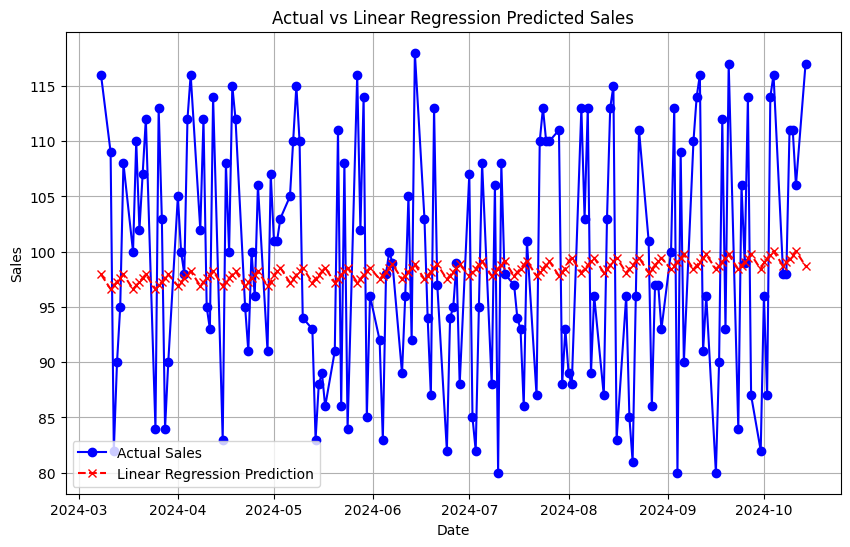

In [57]:
import matplotlib.pyplot as plt

# Plot Actual vs. Predicted for the Best Model (Linear Regression)
plt.figure(figsize=(10,6))
plt.plot(best_model_df['Date'], best_model_df['Actual Sales'], label='Actual Sales', color='blue', marker='o')
plt.plot(best_model_df['Date'], best_model_df['Linear Regression Prediction'], label='Linear Regression Prediction', color='red', linestyle='--', marker='x')
plt.title('Actual vs Linear Regression Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#Save the Table as a CSV File


In [ ]:
# Save the table with Actual Sales and Linear Regression Predictions
best_model_df.to_csv('best_model_lr_predictions.csv', index=False)

In [ ]:
from google.colab import files
files.download('best_model_lr_predictions.csv')

#Forecasting

## Forcast for the next 90 Days "Week"

In [58]:
# Ensure the index of the test set is in datetime format
test.index = pd.to_datetime(test.index)

In [59]:
# Create a range of dates for the next 3 months (using the last date in the test set)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=90, freq='B')  # 'B' ensures business days (weekdays only)

# Display the generated future dates
future_dates

DatetimeIndex(['2024-10-15', '2024-10-16', '2024-10-17', '2024-10-18',
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01', '2024-11-04', '2024-11-05',
               '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-11',
               '2024-11-12', '2024-11-13', '2024-11-14', '2024-11-15',
               '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21',
               '2024-11-22', '2024-11-25', '2024-11-26', '2024-11-27',
               '2024-11-28', '2024-11-29', '2024-12-02', '2024-12-03',
               '2024-12-04', '2024-12-05', '2024-12-06', '2024-12-09',
               '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13',
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-30', '2024-12-31',
      

In [60]:
# Future dates (next 3 months)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=90, freq='B')

# Future features (day_of_week, month, year)
future_df = pd.DataFrame({
    'date': future_dates,
    'day_of_week': future_dates.dayofweek,
    'month': future_dates.month,
    'year': future_dates.year
})

# Set index
future_df.set_index('date', inplace=True)

# Predict sales for next 3 months using Linear Regression
future_sales_pred = lr_model.predict(future_df[['day_of_week', 'month', 'year']])

# Create DataFrame to store predictions
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Sales': future_sales_pred
})

# Display forecasted sales
forecast_df.head()

,Date,Predicted Sales
0,2024-10-15,99.039286
1,2024-10-16,99.375210
2,2024-10-17,99.711134
3,2024-10-18,100.047058
4,2024-10-21,98.703362


In [61]:
# Create future dates for the next 3 months (90 business days)
future_dates = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=90, freq='B')

# Prepare future features (day_of_week, month, year)
future_df = pd.DataFrame({
    'date': future_dates,
    'day_of_week': future_dates.dayofweek,
    'month': future_dates.month,
    'year': future_dates.year
})

# Set index
future_df.set_index('date', inplace=True)

In [62]:
# Predict sales for the next 3 months using Linear Regression
lr_forecast = lr_model.predict(future_df[['day_of_week', 'month', 'year']])

In [63]:
# Forecast using ARIMA model
arima_forecast = arima_result.forecast(steps=90)

In [64]:
# Forecast using SARIMA model
sarima_forecast = sarima_result.forecast(steps=90)

In [65]:
# Prepare future DataFrame for Prophet model
future_prophet_df = prophet_model.make_future_dataframe(periods=90)
forecast_prophet = prophet_model.predict(future_prophet_df)

# Extract predictions for the future period
prophet_forecast = forecast_prophet['yhat'][-90:].values

In [66]:
# Predict sales for the next 3 months using Random Forest
rf_forecast = rf_model.predict(future_df[['day_of_week', 'month', 'year']])

In [67]:
# Predict sales for the next 3 months using XGBoost
xgb_forecast = xgb_model.predict(future_df[['day_of_week', 'month', 'year']])

In [68]:
# Create a DataFrame to compare forecasts from all models
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Linear Regression': lr_forecast,
    'ARIMA': arima_forecast,
    'SARIMA': sarima_forecast,
    'Prophet': prophet_forecast,
    'Random Forest': rf_forecast,
    'XGBoost': xgb_forecast
})

# Display the forecast table
forecast_df.head()


,Date,Linear Regression,ARIMA,SARIMA,Prophet,Random Forest,XGBoost
365,2024-10-15,99.039286,97.563209,97.250616,99.129882,90.319214,84.127205
366,2024-10-16,99.375210,96.296748,98.873813,90.382579,97.952960,93.833435
367,2024-10-17,99.711134,93.073838,101.045357,90.377969,95.086254,98.612297
368,2024-10-18,100.047058,95.106985,98.274770,97.869880,110.661071,113.561043
369,2024-10-21,98.703362,97.064785,97.863043,97.513810,93.423538,88.234039


In [80]:
# Save the forecast DataFrame to a CSV file
forecast_df.to_csv('sales_forecasts.csv', index=False)

# If using Google Colab, download the file
from google.colab import files
files.download('sales_forecasts.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
import matplotlib.pyplot as plt

def visualize_forecast(model_name, actual_sales, forecast, dates_actual, dates_forecast):
    """
    Visualizes the actual sales and forecast for a given model.

    Parameters:
    - model_name: The name of the model (string).
    - actual_sales: The actual sales values.
    - forecast: The forecasted sales values.
    - dates_actual: Dates for actual sales.
    - dates_forecast: Dates for the forecast period.
    """
    plt.figure(figsize=(10, 6))

    # Plot the actual sales
    plt.plot(dates_actual, actual_sales, label='Actual Sales', color='blue', marker='o')

    # Plot the forecasted sales
    plt.plot(dates_forecast, forecast, label=f'{model_name} Forecast', linestyle='--', color='red')

    # Add titles and labels
    plt.title(f'Actual Sales vs {model_name} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

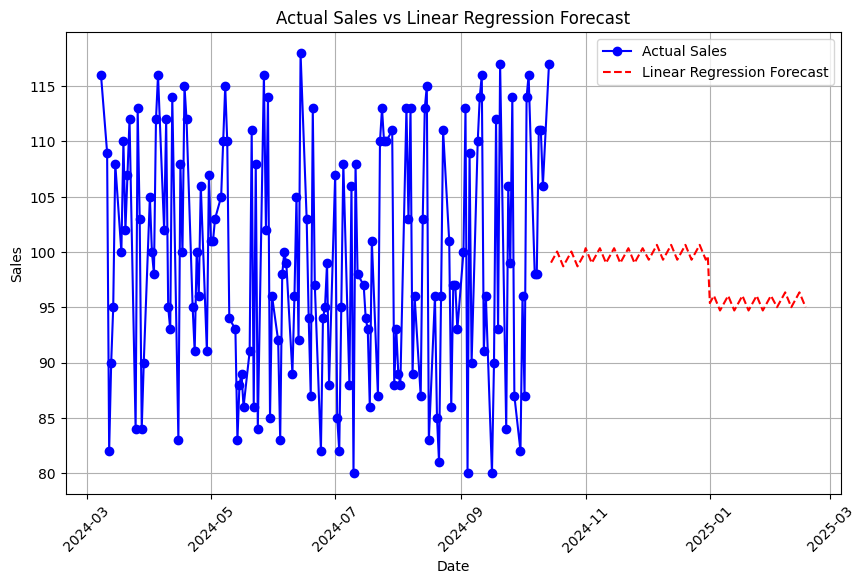

In [81]:
visualize_forecast(
    model_name='Linear Regression',
    actual_sales=test['sales'],  # Historical actual sales
    forecast=lr_forecast,  # Forecasted sales from Linear Regression
    dates_actual=test.index,  # Dates for actual sales
    dates_forecast=future_dates  # Future forecasted dates
)

### Other Visuals for forecast

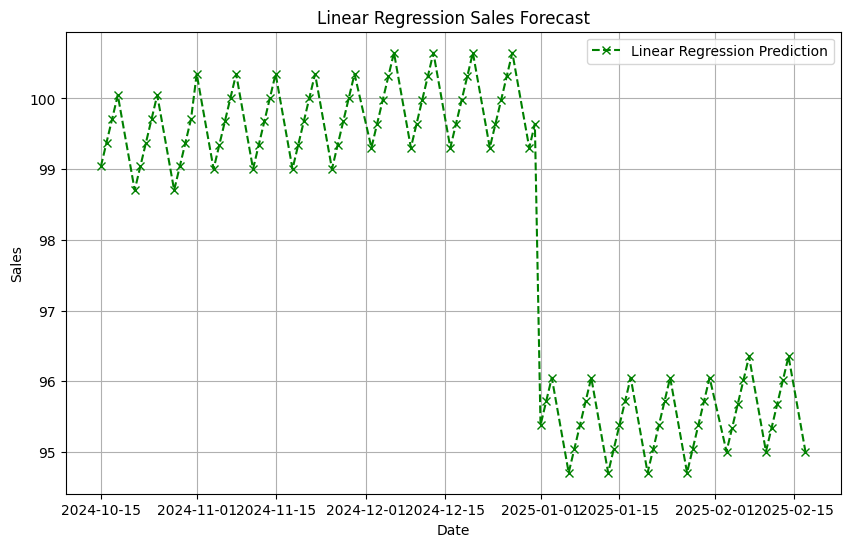

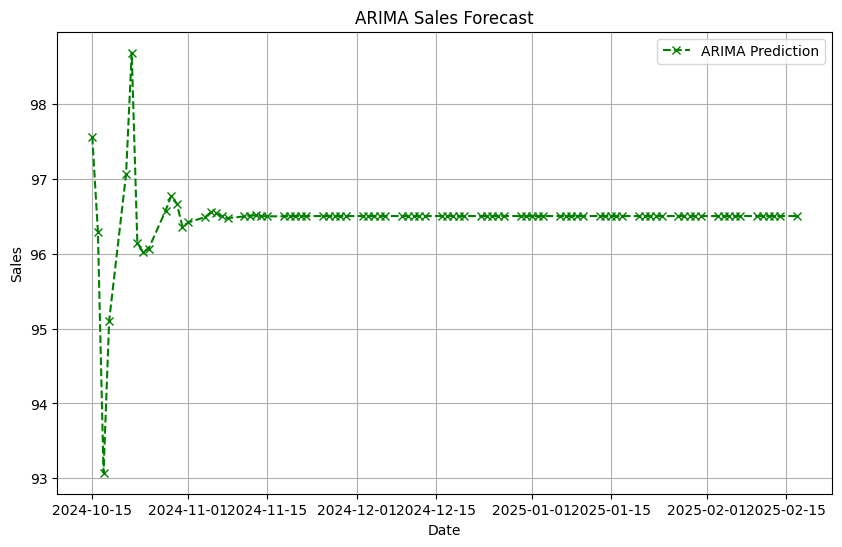

In [69]:
import matplotlib.pyplot as plt

def visualize_forecast(model_name, forecast, future_dates, actual=None):
    """
    Visualizes the forecast for a given model along with the actual sales (if provided).

    Parameters:
    - model_name: The name of the model (string).
    - forecast: The forecasted sales values.
    - future_dates: The dates for the forecast period.
    - actual: The actual sales values (optional, default is None).
    """
    plt.figure(figsize=(10,6))
    plt.plot(future_dates, forecast, label=f'{model_name} Prediction', color='green', linestyle='--', marker='x')

    if actual is not None:
        plt.plot(actual.index, actual['sales'], label='Actual Sales', color='blue', marker='o')

    plt.title(f'{model_name} Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for Linear Regression
visualize_forecast('Linear Regression', lr_forecast, future_dates)

# Example usage for ARIMA
visualize_forecast('ARIMA', arima_forecast, future_dates)

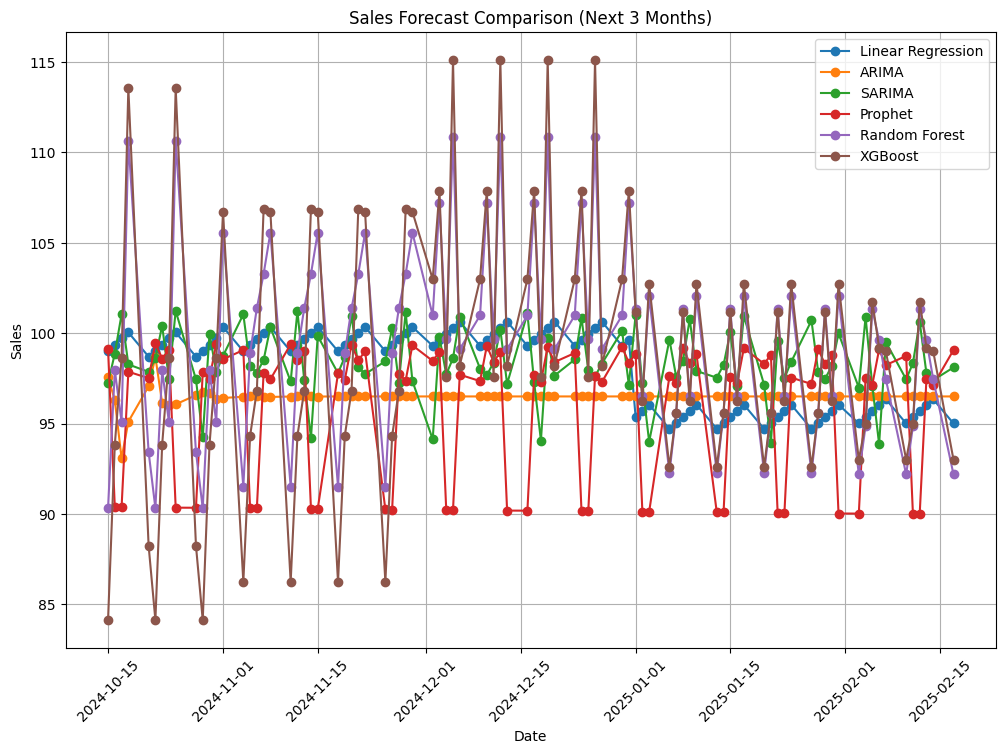

In [70]:
def compare_forecasts(forecast_df):
    """
    Function to visualize and compare forecasts from multiple models.

    Parameters:
    forecast_df (pd.DataFrame): DataFrame containing the Date and forecasts from multiple models.
    """
    plt.figure(figsize=(12, 8))

    # Plot forecasts from all models
    for column in forecast_df.columns[1:]:
        plt.plot(forecast_df['Date'], forecast_df[column], label=column, marker='o')

    # Plot formatting
    plt.title('Sales Forecast Comparison (Next 3 Months)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.show()

# Call the function to compare all forecasts
compare_forecasts(forecast_df)


# Combine the Data and Predictions


In [74]:
import numpy as np

# Fill the prediction arrays with NaN values to match the length of the test set
arima_pred_filled = np.append(arima_pred, [np.nan] * (len(test) - len(arima_pred)))
sarima_pred_filled = np.append(sarima_pred, [np.nan] * (len(test) - len(sarima_pred)))
prophet_pred_filled = np.append(prophet_pred, [np.nan] * (len(test) - len(prophet_pred)))
rf_pred_filled = np.append(rf_pred, [np.nan] * (len(test) - len(rf_pred)))
xgb_pred_filled = np.append(xgb_pred, [np.nan] * (len(test) - len(xgb_pred)))
lr_pred_filled = np.append(lr_pred, [np.nan] * (len(test) - len(lr_pred)))

# Now all predictions should match the length of the test set

In [75]:
# Create the comparison DataFrame
comparison_df = pd.DataFrame({
    'Date': test.index,  # Use the full test index (314 rows)
    'Actual Sales': test['sales'],  # Actual sales data
    'ARIMA Prediction': arima_pred_filled,  # ARIMA predictions filled with NaN
    'SARIMA Prediction': sarima_pred_filled,  # SARIMA predictions filled with NaN
    'Prophet Prediction': prophet_pred_filled,  # Prophet predictions filled with NaN
    'Random Forest Prediction': rf_pred_filled,  # Random Forest predictions filled with NaN
    'XGBoost Prediction': xgb_pred_filled,  # XGBoost predictions filled with NaN
    'Linear Regression Prediction': lr_pred_filled  # Linear Regression predictions filled with NaN
})

# Display the comparison DataFrame to ensure everything is aligned
comparison_df.head()

,Date,Actual Sales,ARIMA Prediction,SARIMA Prediction,Prophet Prediction,Random Forest Prediction,XGBoost Prediction,Linear Regression Prediction
date,,,,,,,,
2024-03-08,2024-03-08,116,97.563209,97.250616,99.129882,111.574690,119.002052,97.950215
2024-03-11,2024-03-11,109,96.296748,98.873813,90.382579,84.006683,82.963219,96.606519
2024-03-12,2024-03-12,82,93.073838,101.045357,90.377969,89.107321,84.022896,96.942443
2024-03-13,2024-03-13,90,95.106985,98.274770,97.869880,90.641045,84.036377,97.278367
2024-03-14,2024-03-14,95,97.064785,97.863043,97.513810,107.603690,113.976387,97.614291


In [82]:
# Save the comparison DataFrame to a CSV file
comparison_df.to_csv('sales_predictions_comparison.csv', index=False)

# If using Google Colab, download the file
from google.colab import files
files.download('sales_predictions_comparison.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>